# Minimal example - Pytorch API

## Define nn.Module with feature extractor network

Notes:
* In the forward funcition one must define the `self.feature_maps = [some_tensor, another_tensor]` parameter. This parameter is used by the `PytorchReceptiveField` to get the desired feature maps. 
* The feature_maps is a list of tensors of shape [batch_size, num_channels, height, width].

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SPP + StripPool

In [18]:
import torch
import torch.nn as nn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function, Variable

def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1):
    """3x3 convolution"""
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=False,
    )
    
class SPP(nn.Module):
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super(SPP,self).__init__() 
        self.m = nn.ModuleList([
            nn.MaxPool2d(ki, stride=1, padding=ki//2) for ki in k
        ])

        self.conv = nn.Conv2d(c1 * 4, c2, 1, 1)

    def forward(self, x):
        return self.conv(torch.cat([x] + [m(x) for m in self.m], 1))

class StripPool(nn.Module):
    def __init__(self, in_channels, channels):
        super().__init__()
        self.pool1 = nn.AdaptiveAvgPool2d((1, None))
        self.pool2 = nn.AdaptiveAvgPool2d((None, 1))

        inter_channels = int(in_channels / 2)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(True),
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(inter_channels, inter_channels,
                      (1, 3), 1, (0, 1), bias=False),
            nn.BatchNorm2d(inter_channels),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(inter_channels, inter_channels,
                      (3, 1), 1, (1, 0), bias=False),
            nn.BatchNorm2d(inter_channels),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, bias=False),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        _, _, h, w = x.size()
        x = self.conv1x1(x)

        x1 = F.interpolate(self.conv1(self.pool1(x)), (h, w))
        x2 = F.interpolate(self.conv2(self.pool2(x)), (h, w))
        x = self.conv3(torch.cat([x1, x2], dim=1))
        return x


## ASPP

In [19]:
class _ImagePool(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = _ConvBnReLU(in_ch, out_ch, 1, 1, 0, 1)

    def forward(self, x):
        _, _, H, W = x.shape
        h = self.pool(x)
        h = self.conv(h)
        h = F.interpolate(h, size=(H, W), mode="bilinear", align_corners=False)
        return h

class _ConvBnReLU(nn.Sequential):
    """
    Cascade of 2D convolution, batch norm, and ReLU.
    """

    BATCH_NORM = nn.BatchNorm2d

    def __init__(
        self, in_ch, out_ch, kernel_size, stride, padding, dilation, relu=True
    ):
        super(_ConvBnReLU, self).__init__()
        self.add_module(
            "conv",
            nn.Conv2d(
                in_ch, out_ch, kernel_size, stride, padding, dilation, bias=False
            ),
        )
        self.add_module("bn", nn.BatchNorm2d(
            out_ch, eps=1e-5, momentum=1 - 0.999))

        if relu:
            self.add_module("relu", nn.ReLU())


class _ASPP(nn.Module):
    """
    Atrous spatial pyramid pooling with image-level feature
    """

    def __init__(self, in_ch, out_ch, rates=[1, 3, 6]):
        super(_ASPP, self).__init__()
        self.stages = nn.Module()
        self.stages.add_module("c0", _ConvBnReLU(in_ch, out_ch, 1, 1, 0, 1))
        for i, rate in enumerate(rates):
            self.stages.add_module(
                "c{}".format(i + 1),
                _ConvBnReLU(in_ch, out_ch, 3, 1, padding=rate, dilation=rate),
            )
        self.stages.add_module("imagepool", _ImagePool(in_ch, out_ch))
        self.conv1x1 = nn.Conv2d(in_ch * 5, out_ch, kernel_size=1, stride=1,padding=0)

    def forward(self, x):
        x = torch.cat([stage(x) for stage in self.stages.children()], dim=1)
        return self.conv1x1(x)

## DCN

In [20]:

from torch.autograd import Variable, Function
import torch
from torch import nn
import numpy as np


class DeformConv2D(nn.Module):
    def __init__(self, inc, outc, kernel_size=3, padding=1, bias=None):
        super(DeformConv2D, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv_kernel = nn.Conv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

    def forward(self, x, offset):
        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        # Change offset's order from [x1, x2, ..., y1, y2, ...] to [x1, y1, x2, y2, ...]
        # Codes below are written to make sure same results of MXNet implementation.
        # You can remove them, and it won't influence the module's performance.
        offsets_index = Variable(torch.cat([torch.arange(0, 2*N, 2), torch.arange(1, 2*N+1, 2)]), requires_grad=False).type_as(x).long()
        offsets_index = offsets_index.unsqueeze(dim=0).unsqueeze(dim=-1).unsqueeze(dim=-1).expand(*offset.size())
        offset = torch.gather(offset, dim=1, index=offsets_index)
        # ------------------------------------------------------------------------

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = Variable(p.data, requires_grad=False).floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], -1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], -1)

        # (b, h, w, N)
        mask = torch.cat([p[..., :N].lt(self.padding)+p[..., :N].gt(x.size(2)-1-self.padding),
                          p[..., N:].lt(self.padding)+p[..., N:].gt(x.size(3)-1-self.padding)], dim=-1).type_as(p)
        mask = mask.detach()
        floor_p = p - (p - torch.floor(p))
        p = p*(1-mask) + floor_p*mask
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv_kernel(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = np.meshgrid(range(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
                          range(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1), indexing='ij')
        # (2N, 1)
        p_n = np.concatenate((p_n_x.flatten(), p_n_y.flatten()))
        p_n = np.reshape(p_n, (1, 2*N, 1, 1))
        p_n = Variable(torch.from_numpy(p_n).type(dtype), requires_grad=False)

        return p_n

    @staticmethod
    def _get_p_0(h, w, N, dtype):
        p_0_x, p_0_y = np.meshgrid(range(1, h+1), range(1, w+1), indexing='ij')
        p_0_x = p_0_x.flatten().reshape(1, 1, h, w).repeat(N, axis=1)
        p_0_y = p_0_y.flatten().reshape(1, 1, h, w).repeat(N, axis=1)
        p_0 = np.concatenate((p_0_x, p_0_y), axis=1)
        p_0 = Variable(torch.from_numpy(p_0).type(dtype), requires_grad=False)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset

class DCN(nn.Module):
    def __init__(self, inplanes, outplanes):
        super(DCN,self).__init__()
        self.offsets = nn.Conv2d(inplanes, 9, kernel_size=3,padding=1)
        self.dcn = DeformConv2D(inplanes, outplanes, kernel_size=3,padding=1)
    
    def forward(self, x):
        offset = self.offsets(x)
        return self.dcn(x, offset)


class DeformNet(nn.Module):
    def __init__(self):
        super(DeformNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2),


        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2),

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2),

        self.offsets = nn.Conv2d(128, 18, kernel_size=3, padding=1)
        self.conv4 = DeformConv2D(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

    def forward(self, x):
        self.feature_maps = []
        # convs
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        self.feature_maps.append(x)
        # deformable convolution
        offsets = self.offsets(x)
        x = self.conv4(x, offsets)
        self.feature_maps.append(x)
        return x 


## RFBNet

In [21]:
class BasicConv(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 relu=True,
                 bn=True,
                 bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes,
                              out_planes,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=dilation,
                              groups=groups,
                              bias=bias)
        self.bn = nn.BatchNorm2d(
            out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x
class BasicRFB(nn.Module):
    '''
    [rfb]
    filters = 128
    stride = 1 or 2
    scale = 1.0
    '''

    def __init__(self, in_planes, out_planes, stride=1, scale=0.1, visual=1):
        super(BasicRFB, self).__init__()
        self.scale = scale
        self.out_channels = out_planes
        inter_planes = in_planes // 8
        self.branch0 = nn.Sequential(
            BasicConv(in_planes,
                      2 * inter_planes,
                      kernel_size=1,
                      stride=stride),
            BasicConv(2 * inter_planes,
                      2 * inter_planes,
                      kernel_size=3,
                      stride=1,
                      padding=visual,
                      dilation=visual,
                      relu=False))
        self.branch1 = nn.Sequential(
            BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
            BasicConv(inter_planes,
                      2 * inter_planes,
                      kernel_size=(3, 3),
                      stride=stride,
                      padding=(1, 1)),
            BasicConv(2 * inter_planes,
                      2 * inter_planes,
                      kernel_size=3,
                      stride=1,
                      padding=visual + 1,
                      dilation=visual + 1,
                      relu=False))
        self.branch2 = nn.Sequential(
            BasicConv(in_planes, inter_planes, kernel_size=1, stride=1),
            BasicConv(inter_planes, (inter_planes // 2) * 3,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            BasicConv((inter_planes // 2) * 3,
                      2 * inter_planes,
                      kernel_size=3,
                      stride=stride,
                      padding=1),
            BasicConv(2 * inter_planes,
                      2 * inter_planes,
                      kernel_size=3,
                      stride=1,
                      padding=2 * visual + 1,
                      dilation=2 * visual + 1,
                      relu=False))

        self.ConvLinear = BasicConv(6 * inter_planes,
                                    out_planes,
                                    kernel_size=1,
                                    stride=1,
                                    relu=False)
        self.shortcut = BasicConv(in_planes,
                                  out_planes,
                                  kernel_size=1,
                                  stride=stride,
                                  relu=False)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)

        out = torch.cat((x0, x1, x2), 1)
        out = self.ConvLinear(out)
        short = self.shortcut(x)
        out = out * self.scale + short
        out = self.relu(out)

        return out


## Stem Network

In [22]:

class Linear(nn.Module):
    """An identity activation function"""
    def forward(self, x):
        return x
    
class BasicBlock(nn.Module):
    def __init__(self, inplanes, stride, plugin):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, inplanes, stride)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(inplanes, inplanes)
        self.bn2 = nn.BatchNorm2d(inplanes)
        self.downsample = lambda x: x
        self.stride = stride
        self.plugin = plugin(inplanes, inplanes)

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.plugin(out)
        out = out + residual
        out = self.relu(out)
        return out

class SimpleVGG(nn.Module):
    def __init__(self, disable_activations: bool = True):
        """disable_activations: whether to generate network with Relus or not."""
        super(SimpleVGG, self).__init__()
        self.features = self._make_layers(disable_activations)

    def forward(self, x):
        # index of layers with feature maps
        select = [8,9]
        # self.feature_maps is a list of Tensors, PytorchReceptiveField looks for 
        # this parameter and compute receptive fields for Tensors in self.feature_maps.
        self.feature_maps = []
        for l, layer in enumerate(self.features):
            x = layer(x)
            if l in select:
                self.feature_maps.append(x)
        return x

    def _make_layers(self, disable_activations: bool):
        activation = lambda: Linear() if disable_activations else nn.ReLU()
        layers = [
            nn.Conv2d(3, 64, kernel_size=3),
            activation(),
            nn.Conv2d(64, 64, kernel_size=3),
            activation(),
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=1),
            activation(),
            nn.Conv2d(128, 128, kernel_size=1),
            activation(), # 8
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 256, kernel_size=3),
            # activation(),
            # nn.Conv2d(256, 256, kernel_size=3),
            # activation(), # 13
            
            BasicBlock(128, 1, SPP)
            # DCN(256,256),
            
        ]        
        return nn.Sequential(*layers)    

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.module = SPP(3,3)
    
    def forward(self, x):
        self.feature_maps = []
        self.feature_maps.append(x)
        x = self.module(x)
        self.feature_maps.append(x)
        return x 
        

## Define model build function
Notes:
* In the case when using layers which behave differently on training and eval modes, it is recommended to set model to an eval mode: `model.eval()`

In [23]:
def model_fn() -> nn.Module:
    # model = SimpleVGG(disable_activations=True)
    # model = DeformNet()
    model = SimpleCNN()
    model.eval()
    print(model)
    return model

## Run RF estimation

In [24]:
import sys 
import os 
sys.path.insert(0, "..")

from receptivefields.pytorch import PytorchReceptiveField

input_shape = [32, 32, 3]
rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape) 

[2022-03-09 16:40:37,497][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=32, h=32, c=3), GridShape(n=1, w=32, h=32, c=3)]
[2022-03-09 16:40:37,498][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=32, h=32, c=3)
[2022-03-09 16:40:37,541][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(0.5, 0.5), stride=(1.0, 1.0), size=Size(w=1, h=1))
[2022-03-09 16:40:37,541][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(-1.0, -1.0), stride=(1.0, 1.0), size=Size(w=4, h=4))


SimpleCNN(
  (module): SPP(
    (m): ModuleList(
      (0): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=9, stride=1, padding=4, dilation=1, ceil_mode=False)
      (2): MaxPool2d(kernel_size=13, stride=1, padding=6, dilation=1, ceil_mode=False)
    )
    (conv): Conv2d(12, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [25]:
rf.feature_maps_desc

[FeatureMapDescription(size=Size(w=32, h=32), rf=ReceptiveFieldDescription(offset=(0.5, 0.5), stride=(1.0, 1.0), size=Size(w=1, h=1))),
 FeatureMapDescription(size=Size(w=32, h=32), rf=ReceptiveFieldDescription(offset=(-1.0, -1.0), stride=(1.0, 1.0), size=Size(w=4, h=4)))]

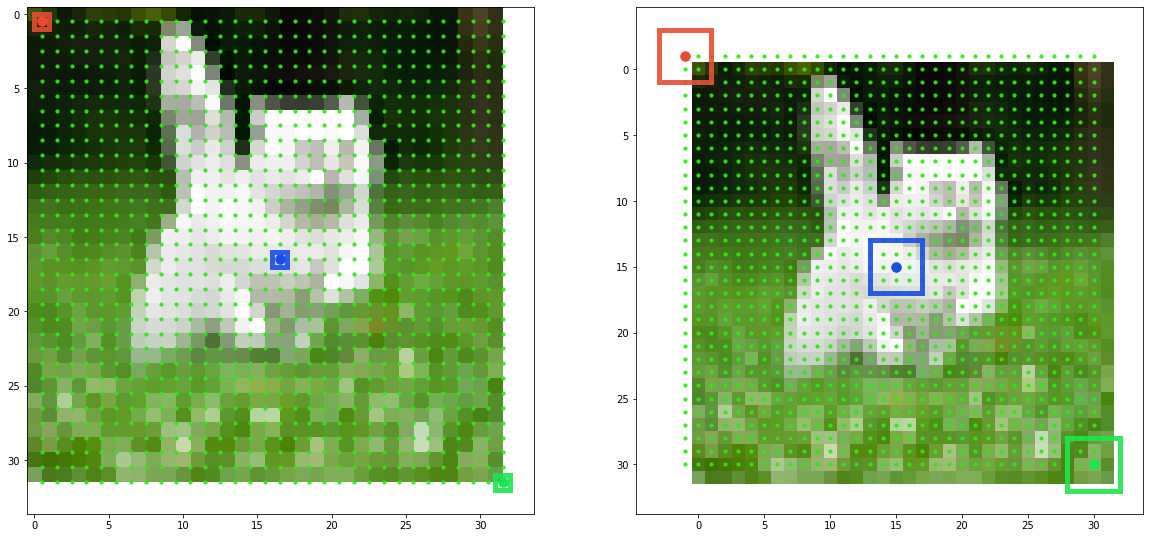

In [26]:
import sys 
import os 
from PIL import Image

from receptivefields.image import get_default_image,tile_pil_image

imgt = Image.open(r"E:\GitHub\SimpleCVReproduction\easy-receptive-fields-pytorch\receptivefield\receptivefields\resources\cat.jpg", mode="r")
imgt = imgt.resize((input_shape[0], input_shape[1]), Image.ANTIALIAS)
imgt = tile_pil_image(imgt, tile_factor=0, shade=True)


rf.plot_rf_grids(imgt, figsize=(20, 12), layout=(1, 2))

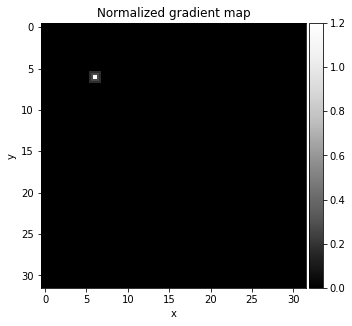

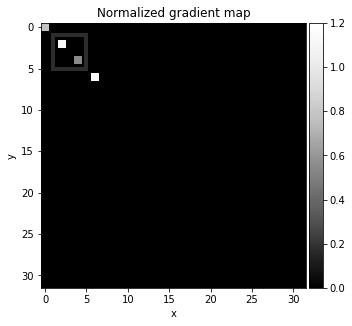

In [27]:
rf.plot_gradient_at(fm_id=0, point=(6, 6))
rf.plot_gradient_at(fm_id=1, point=(6, 6))

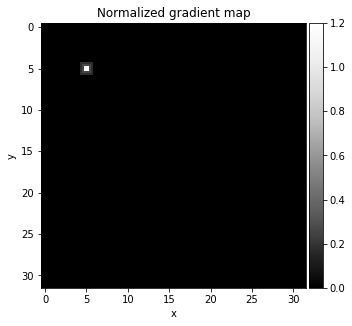

In [28]:
rf.plot_gradient_at(fm_id=0, point=(5, 5))

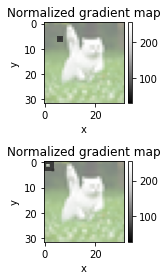

In [29]:
import numpy as np
rf.plot_gradients_at(points=[(6, 6),(3,3)], image=np.array(imgt))

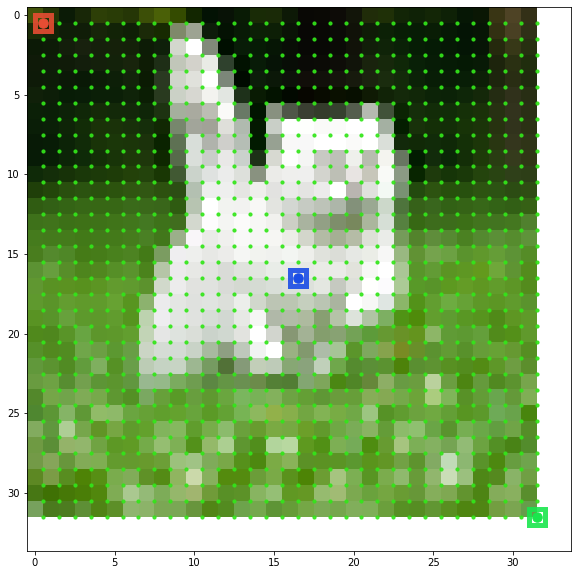

In [30]:
rf.plot_rf_grid(fm_id=0, custom_image=imgt)

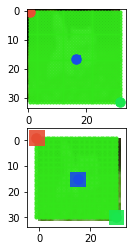

In [31]:
rf.plot_rf_grids(custom_image=imgt)

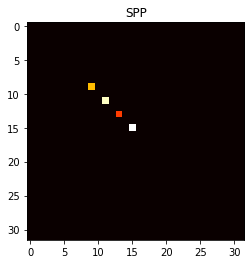

In [36]:
from receptivefields.types import GridPoint
rf.plot_gradient_self(fm_id=1, point=GridPoint(15,15), title="SPP")